In [1]:
import sys
sys.path.append("../learn_poly_sampling")

In [2]:
import numpy as np 
import torch 
import torch.nn as nn
from matplotlib import pyplot as plt

from PIL import Image
from functools import partial
from layers import get_logits_model, get_antialias
from layers import PolyphaseInvariantDown2D, LPS, PolyphaseInvariantUp2D, LPS_u
from layers.polydown import set_pool
from layers.polyup import set_unpool

In [11]:
# Define Model
class SimpleUNet(nn.Module):
    def __init__(self, num_classes=3,padding_mode='circular'):
        # Conv. Layer
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, padding_mode=padding_mode)
        # Learnable Polyphase Downsampling Layer
        self.lpd = set_pool(partial(
            PolyphaseInvariantDown2D,
            component_selection=LPS,
            get_logits=get_logits_model('LPSLogitLayers'),
            pass_extras=False
            ),p_ch=32,h_ch=32)
        # Conv. Layer
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode=padding_mode)
        # Learnable Polyphase Upsampling Layer
        antialias_layer = get_antialias(antialias_mode='LowPassFilter',
                                    antialias_size=3,
                                    antialias_padding='same',
                                    antialias_padding_mode='circular',
                                    antialias_group=1)
        self.lpu = set_unpool(partial(
            PolyphaseInvariantUp2D,
            component_selection=LPS_u,
            antialias_layer=antialias_layer), p_ch=32)
    def forward(self,x):
        x = self.conv1(x)
        x, prob = self.lpd(x,ret_prob=True)  # Use just as any down-sampling layer!
        x = self.conv2(x)
        x = self.lpu(x,prob=prob)
        return x

In [15]:
# Construct Model
torch.manual_seed(0)
model = SimpleUNet().cuda().eval().double()
# Load Image
img = torch.from_numpy(np.array(Image.open('butterfly.png'))).permute(2,0,1)
img = img.unsqueeze(0).cuda().double()

In [19]:
# Check is circular shift equivariant
y_orig = model(img).detach().cpu()
img_roll = torch.roll(img,shifts=(1, 1), dims=(-1, -2))
y_roll = model(img_roll).detach().cpu()
y_roll_s = torch.roll(y_roll, shifts=(-1,-1), dims=(-1, -2))
print("Norm(y_orig-y_roll_s): %e" % torch.norm(y_orig-y_roll_s))
assert torch.allclose(y_orig, y_roll_s)
y_orig = y_orig[0].permute(1,2,0).cpu().detach().numpy()
y_roll_s = y_roll_s[0].permute(1,2,0).cpu().detach().numpy()

Norm(y_orig-y_roll_s): 0.000000e+00


Visualization of y_orig


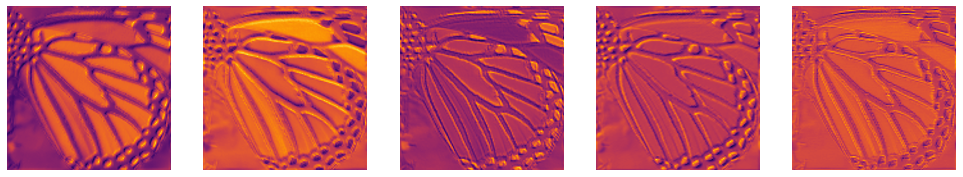

Visualization of y_roll_s


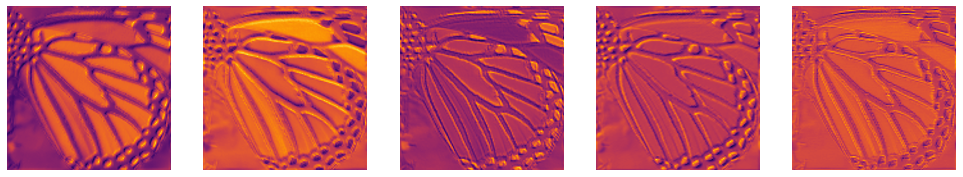

<Figure size 432x288 with 0 Axes>

In [20]:
# Visualize result
plt.figure(figsize=(17,17))
for k in range(1,6):
    plt.subplot(1, 5, k)
    plt.imshow(y_orig[:,:,k-1]/255)
    plt.axis('off')
print('Visualization of y_orig')
plt.show()
print('Visualization of y_roll_s')
plt.figure(figsize=(17,17))
for k in range(1,6):
    plt.subplot(1, 5, k)
    plt.imshow(y_roll_s[:,:,k-1]/255)
    plt.axis('off')
plt.show()
plt.set_cmap('inferno')